In [1]:
import generate_visual_bars_data as vbd

from cluster_methods import kmeans
from density_estimation_methods import condExp
import tensorflow as tf #if it gets mad about importing tensorflow, make sure you're in the right virtual environment
import numpy as np 

import core_cfl_objects.two_step_cfl as tscfl

In [2]:
# generate visual bars data 
n_samples = 1000
im_shape = (10, 10)
vb_data = vbd.VisualBarsData(n_samples=n_samples, im_shape = im_shape, noise_lvl=0)

x = vb_data.getImages()
print(x[0:10])
y = vb_data.getTarget()
print(y[0:10])


#reformat x, y into the right shape for the neural net 
y = np.expand_dims(y, -1)
x = np.reshape(x, (x.shape[0], x.shape[1]*x.shape[2])) 


[[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]

 [[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]]

 [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0

In [3]:
# parameters for CDE 
optimizer_Adam = tf.keras.optimizers.Adam(lr=1e-3)
condExp_params = {'batch_size': 128, 'lr': 1e-3, 'optimizer': optimizer_Adam, 'n_epochs': 200, 'test_every': 10, 'save_every': 10}
data_info = {'X_dims': x.shape, 'Y_dims': y.shape} #NOTE: I was a little confused here about how to enter the dimensions until I realized to just get the shape from the np function 
print(data_info)

# generate CDE object
condExp_object = condExp.CondExp(data_info, condExp_params, True)



{&#39;X_dims&#39;: (1000, 100), &#39;Y_dims&#39;: (1000, 1)}


In [4]:
# generate clusterer 
cluster_params = {'n_Xclusters':4, 'n_Yclusters':4}
cluster_object = kmeans.KMeans(cluster_params)


# put into a cfl core object 
cfl_object = tscfl.Two_Step_CFL_Core(condExp_object, cluster_object)

Model: &quot;model&quot;
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
nn_input_layer (InputLayer)  [(None, 100)]             0         
_________________________________________________________________
nn_dropout1 (Dropout)        (None, 100)               0         
_________________________________________________________________
nn_dense1 (Dense)            (None, 50)                5050      
_________________________________________________________________
nn_dropout2 (Dropout)        (None, 50)                0         
_________________________________________________________________
nn_layer2 (Dense)            (None, 10)                510       
_________________________________________________________________
nn_dropout3 (Dropout)        (None, 10)                0         
_________________________________________________________________
nn_output_layer (Dense)      (None, 1)             

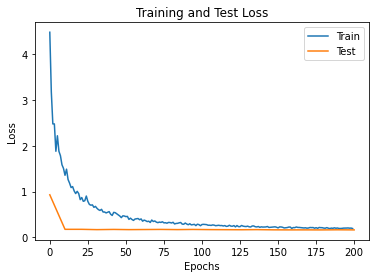

100%|██████████| 1000/1000 [00:00&lt;00:00, 1489.78it/s]


In [5]:
x_lbls, y_lbls = cfl_object.train(x, y)

# and then run visual bars through that 
# see what we get 

In [14]:
# check the results of CFL against the original 
truth=vb_data.getGroundTruth().astype(int)

print(truth[0:20])
print(x_lbls[0:20])

print(np.sum(x_lbls==0), np.sum(x_lbls==1), np.sum(x_lbls==2), np.sum(x_lbls==3))
print(np.sum(truth==0), np.sum(truth==1), np.sum(truth==2), np.sum(truth==3))

accuracy1 = (x_lbls == vb_data.getGroundTruth())



def correspond(ground_truth, x_lbls, length_head):
    ''' by sampling the first few entries in ground_truth and x_lbls, 
    determines which class in ground_truth is most likely to correspond 
    to which class in x_lbls'''
    gtHead = ground_truth[0:length_head]
    xHead = x_lbls[0:length_head]
    answers = {}
    for gt_label in [0, 1, 2, 3]: 
        # find the classes that correspond to the current ground truth label 
        currentClasses = np.asarray(gtHead==gt_label).nonzero()
        # figure out, of these, which class label in xHead is most common 
        options = [np.count_nonzero(xHead[currentClasses]==0), np.count_nonzero(xHead[currentClasses]==1), np.count_nonzero(xHead[currentClasses]==2), np.count_nonzero(xHead[currentClasses]==3)]
        answers[str(gt_label)] = np.argmax(options)
    return answers 

mapping = correspond(truth, x_lbls, 100)
print(mapping)

def accuracy(ground_truth, x_lbls, mapping): 
    '''checks the accuracy of the x_lbls against the ground_truth, according to the mapping bt ground_label class names and x_lbl class names'''
    #TODO: warning if not unqieu
    accurate_counter = 0 
    for ground_truth_label in mapping.keys(): 
        ground_truth_label_int = int(ground_truth_label)
        entries_in_gt_class = np.asarray(ground_truth ==ground_truth_label_int).nonzero()
        current_x_lbl = mapping[ground_truth_label]
        accurate_counter += np.sum(x_lbls[entries_in_gt_class]==current_x_lbl)
    return accurate_counter/len(truth)

print("percent correct: ", accuracy(truth, x_lbls, mapping))

[0 1 2 2 2 1 1 3 3 1 2 3 1 1 0 3 1 2 3 0]
[2 0 3 3 0 0 3 1 1 0 3 1 3 3 2 1 3 3 1 2]
172 241 236 351
236 252 259 253
{&#39;0&#39;: 2, &#39;1&#39;: 3, &#39;2&#39;: 3, &#39;3&#39;: 1}
percent correct:  0.816


In [20]:
def createLabelsDict(l): 
    return {'0': l[0], '1': l[1], '2': l[2], '3':l[3]}

from itertools import permutations
def check_whether_correspond_does_okay(ground_truth, x_lbls): 
    all_possible_value_orders = list(permutations([0, 1, 2, 3]))
    all_possible_mappings = [createLabelsDict(permutation) for permutation in all_possible_value_orders]

    bestAccuracy = 0 
    for mapping in all_possible_mappings: 
        # print(mapping)
        #find accuracy 
        currentAcc = accuracy(ground_truth, x_lbls, mapping)
        # print(currentAcc)
        # store mapping w best accuracy 
        if currentAcc > bestAccuracy: 
            bestAccuracy = currentAcc
            bestMapping = mapping
        #return ^that, w accuracy 
    return bestMapping, bestAccuracy

check_whether_correspond_does_okay(truth, x_lbls)

({&#39;0&#39;: 2, &#39;1&#39;: 0, &#39;2&#39;: 3, &#39;3&#39;: 1}, 0.776)

In [7]:
# thoughts: 
# - currently, we have to reshape x and y to get them into the right shape for the neural net, which is annoying
# - it gave y-labels, which we didn't want (they're kind of meaningless in this case? raise a warning to prevent people from doing? )
# - I think we should raise a warning or something if the CDE gets trained twice - cause otherwise you could get confusing graphs from the training/test loss
# the tqdm bar is great, but you can't tell it's referring to the clustering - we should add a print statement ahead of it 
# the import statements are kind of slow - are we double importing stuff? is there are reason they're slow? slash - eventually - we want to be able to just import everything all with one import statement, right? "import cfl" or something
# ACTUAL problem: the way the import statements are, make me able to import from CFL, but if i open a file (eg CDE.py) in the terminal, I can't import things successfully 
# add set_seed to visual bars so that it's repeatable 